In [1]:
%matplotlib notebook

import json
import numpy as np
import numpy.random as npr
import scipy.stats as scs
import matplotlib.pyplot as plt
import matplotlib.ticker as mpt

from ast import literal_eval

In [2]:
BURN_IN = 20

base_parameters = {
    'k_a': 0.002,
    'k_d': 0.1,
    'mu': 3.0,
    'kappa': 1.0,
    'gamma': 0.04,
    'diffusion': 0.6,
    'time_step': 0.1,
    'cell_radius': 6.0,
    'nucleus_radius': 2.5,
}

def log_value(p, name=None):
    return (np.log10(base_parameters[name]) if name else 0) + p * np.log10(2)

def exp_value(p, name=None):
    return (p - (np.log10(base_parameters[name]) if name else 0))/np.log10(2)

In [3]:
with open('data.json', 'r') as f:
    raw_data = {literal_eval(k): v for k, v in json.load(f).items()}
    
for key in raw_data.keys():
    solver, params = key
    timeseries = raw_data[key][1]
            
    if solver == 'CBM':
        for species in ['P', 'RNA']:
            timeseries[species] = np.array(timeseries[species + 'nuc']) + np.array(timeseries[species + 'cyt'])
            del timeseries[species + 'nuc']
            del timeseries[species + 'cyt']
    
    del timeseries['Gf']
    del timeseries['Gb']
    
    for species in timeseries:
        timeseries[species] = np.array(timeseries[species])[:, BURN_IN:]

In [4]:
summary_statistics_raw = {
        'mean': lambda x: np.mean(x, axis=(-1, -2)),
        'std': lambda x: np.std(x, axis=(-1, -2)),
        'min': lambda x: np.min(x, axis=(-1, -2)),
        'max': lambda x: np.max(x, axis=(-1, -2)),
        }

stat_mean = {k + species: np.mean([s(v[1][species]) for v in raw_data.values()])
            for k, s in summary_statistics_raw.items()
            for species in ['P', 'RNA']}

stat_std = {k + species: np.std([s(v[1][species]) for v in raw_data.values()])
            for k, s in summary_statistics_raw.items()
            for species in ['P', 'RNA']}

In [17]:
synthetic_data = [
    (0.8000000000000007, 0.8000000000000003, 0.0),
    (-0.7999999999999998, 0.8000000000000003, 0.0),
    (-4.8, 3.2, 0.0),
][0]

In [18]:
# Estimate noise with bootstrap
K = 100
NTRAJ = 64

var_ss_dist = {solver:
           {k: [] for _, k in raw_data}
           for solver in ['CBM', 'WMM', 'smoldyn']
          }

var_ks_dist = {solver:
           {k: [] for _, k in raw_data}
           for solver in ['CBM', 'WMM', 'smoldyn']
          }

summary_statistics = {
            k + species: lambda x: (s(x) - stat_mean[k + species])/stat_std[k + species]
            for k, s in summary_statistics_raw.items()
            for species in ['P', 'RNA']
        }

# Refactor data
data = {}
for k, v in raw_data.items():
    solver, params = k
    data.setdefault(params, {})[solver] = v

subsample = npr.choice(list(range(NTRAJ)), (K, NTRAJ))

lst_square = lambda x,y: (
        (np.array([summary_statistics[ss + species](x[species][subsample, :])
                   for ss in summary_statistics_raw.keys()
                   for species in ['P', 'RNA']]) # (NSS, K)
        - (np.array([summary_statistics[ss + species](y[species][subsample, :])
                   for ss in summary_statistics_raw.keys()
                   for species in ['P', 'RNA']])) # (NSS, K)
    )**2).sum(axis=0)**0.5

var_ss_dist = {solver:
           {k:
              lst_square(data[synthetic_data]['smoldyn'][1], v[solver][1]).var()
              for k, v in data.items()
              }
           for solver in ['CBM', 'WMM', 'smoldyn']
          }

"""
        #TODO vectorize (not sure how much is possible with ks_2samp)
        ks_dist = {solver:
               {k:
                sum([scs.ks_2samp(
                    data[synthetic_data]['smoldyn'][1][species][subsample,:].reshape(-1),
                    v[solver][1][species][subsample, :].reshape(-1))[0]
                  for species in ['P', 'RNA']])/2
                  for k, v in data.items()
                  if 'smoldyn' in v and solver in v
                  }
               for solver in ['CBM', 'WMM', 'smoldyn']
              }"""

print()

In [19]:
"""summary_statistics = {
            k + species: lambda x: (s(x) - stat_mean[k + species])/stat_std[k + species]
            for k, s in summary_statistics_raw.items()
            for species in ['P', 'RNA']
        }"""

lst_square = lambda x,y: (
        (np.array([summary_statistics[ss + species](x[species])
                   for ss in summary_statistics_raw.keys()
                   for species in ['P', 'RNA']]) # (NSS, K)
        - (np.array([summary_statistics[ss + species](y[species])
                   for ss in summary_statistics_raw.keys()
                   for species in ['P', 'RNA']])) # (NSS, K)
    )**2).sum(axis=0)**0.5


def train_surrogate_dist(target, solver, data):
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RationalQuadratic, ConstantKernel, RBF, WhiteKernel, Matern
    from sklearn import preprocessing
    
    x_scaler = preprocessing.MinMaxScaler()
    y_scaler = preprocessing.MinMaxScaler()

    
    X = [k for k in data.keys() if k[2]==0.] # Ignore k_d
    y = np.array([
         lst_square(data[target]['smoldyn'][1], data[tuple(k)][solver][1])
         for k in X
        ])
        
    kernel = (
        #ConstantKernel() +
        RationalQuadratic()
        #Matern()
        #+ RBF()
        + WhiteKernel()
    )
    gp = GaussianProcessRegressor(
        kernel=kernel,
        #alpha=np.array([var_ss_dist[solver][k] for k in X]),
        n_restarts_optimizer=10,
    )
    
    X_raw = np.array(X)[:, :2]
    x_scaler.fit(X_raw)
    X_norm = x_scaler.transform(X_raw)
    
    y = np.atleast_2d(y).T
    y_scaler = y_scaler.fit(y)
    y_norm = y_scaler.transform(y)
        
    gp.fit(X_norm, y_norm)
    
    return (gp, x_scaler, y_scaler)

gp, x_scl, y_scl = train_surrogate_dist(synthetic_data, 'smoldyn', data)
y_scl.inverse_transform(gp.predict(x_scl.transform(np.atleast_2d(synthetic_data[:2])), return_std=True))

/home/adrien/Documents/Library/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


array([[21.90730839],
       [17.49616663]])

In [20]:
ss_dist = {solver:
           {k:
              lst_square(data[synthetic_data]['smoldyn'][1], v[solver][1])
              for k, v in data.items()
              if 'smoldyn' in v and solver in v
              }
           for solver in ['CBM', 'WMM', 'smoldyn']
          }

<IPython.core.display.Javascript object>


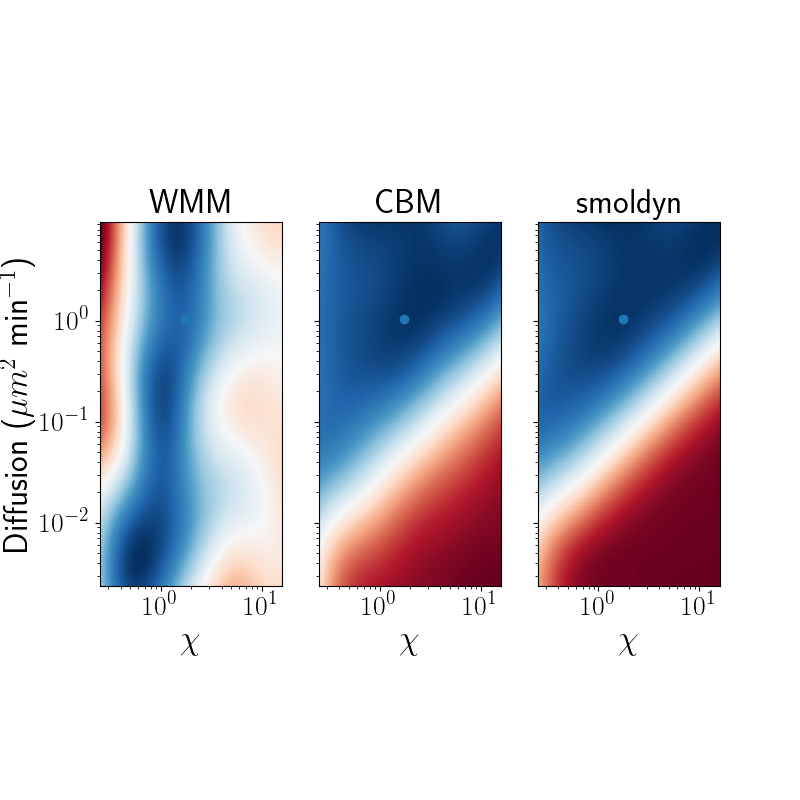

In [21]:
params = {'legend.fontsize': 20,
          #'figure.figsize': (6, 6),
         'figure.figsize': (8, 8),
         'figure.titlesize': 28,
         'axes.labelsize': 24,
         'axes.titlesize':24,
         'xtick.labelsize':20,
         'ytick.labelsize':20,
         'text.usetex':True,
         'figure.autolayout':False,
         }

plt.rcParams.update(params)

import scipy.interpolate as sci
import matplotlib.colors as colors

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
#fig.tight_layout(w_pad=0)

dist = ss_dist

for i, solver in enumerate(['WMM', 'CBM', 'smoldyn']):
    dist_sol = dist[solver]

    min_x = log_value(min(dist_sol.keys(), key=lambda t: t[1])[1])
    max_x = log_value(max(dist_sol.keys(), key=lambda t: t[1])[1])
    min_D = log_value(min(dist_sol.keys(), key=lambda t: t[0])[0], 'diffusion')
    max_D = log_value(max(dist_sol.keys(), key=lambda t: t[0])[0], 'diffusion')
    
    raw_grid = np.array([[log_value(chi), log_value(D, 'diffusion'), z]
                         for ((D, chi, k_d), z) in dist_sol.items()
                        if k_d == 0])

    #XY = raw_grid[:, :2]
    #Z = raw_grid[:, 2]
    gp, x_scl, y_scl = train_surrogate_dist(synthetic_data, solver, data)
    #gp.predict(np.atleast_2d(synthetic_data[:2]), return_std=True)

    xi, yi = np.mgrid[min_x:max_x:100j, min_D:max_D:100j]
    xi = exp_value(xi)
    yi = exp_value(yi, 'diffusion')
    X_test = x_scl.transform(
        np.concatenate((yi.reshape(-1)[:, np.newaxis], xi.reshape(-1)[:, np.newaxis]), axis=1))
    #OBS input must be passed as (D, Chi) to the gaussian process
    grid_z2 = y_scl.inverse_transform(np.atleast_2d(gp.predict(X_test, return_std=True)[0]).T).reshape(xi.shape)

    
    #grid_z2 = sci.griddata(XY, Z, (xi, yi) , method='linear')
    #TODO scale plots!
    #TODO choose better kernel? Something quadratic maybe?

    pcm = ax[i].imshow(grid_z2.T, extent=(min_x, max_x, min_D, max_D),
               #norm=colors.LogNorm(),
               #vmin=0, vmax=800,
               origin='lower', cmap='RdBu_r')

    if not i:
        ax[i].set_ylabel('Diffusion ($\mu m^2$ min$^{-1}$)')

    ax[i].set_xlabel('$\chi$')
    
    ax[i].set_title(f"{solver}")

    xticks = list(range(int(np.ceil(min_x)), int(np.floor(max_x))+1))
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels([f'$10^{{{t}}}$' for t in xticks])
    ax[i].xaxis.set_minor_locator(mpt.FixedLocator(sum([[np.log10(i*c) for i in range(2,10)] for c in [0.001, 0.01, 0.1, 1, 10]],[])))

    yticks = list(range(int(np.ceil(min_D)), int(np.floor(max_D))+1))
    ax[i].set_yticks(yticks)
    ax[i].set_yticklabels([f'$10^{{{t}}}$' for t in yticks])
    ax[i].yaxis.set_minor_locator(mpt.FixedLocator(sum([[np.log10(i*c) for i in range(2,10)] for c in [0.001, 0.01, 0.1, 1, 10]],[])))

    ax[i].scatter(log_value(synthetic_data[1]), log_value(synthetic_data[0], 'diffusion'))
    
#cb = fig.colorbar(pcm, ax=ax[:], location='right', shrink=0.475)
#cb.set_label('$L^2$ distance')

<IPython.core.display.Javascript object>


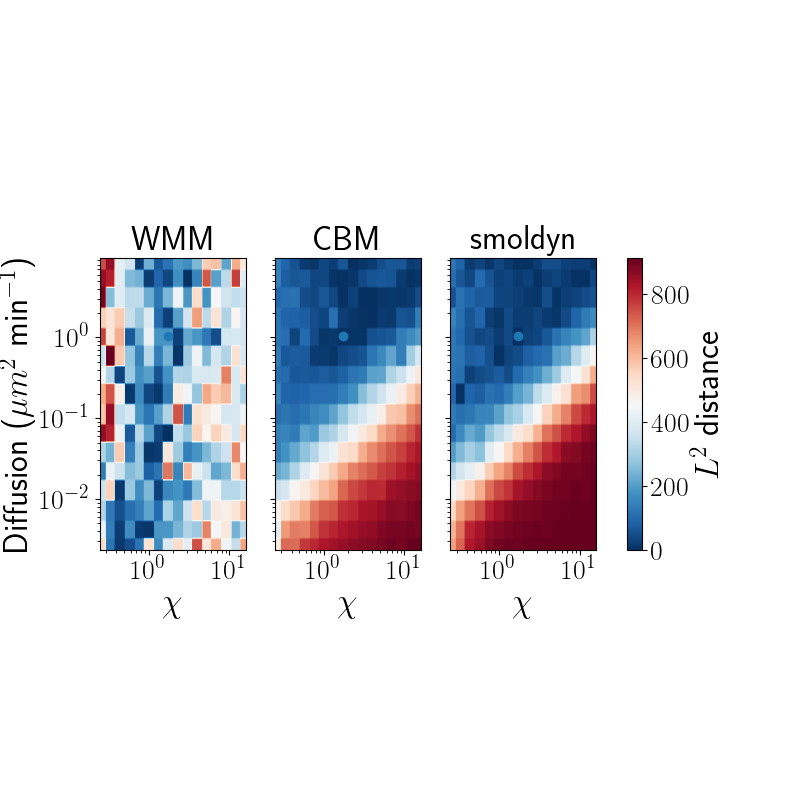

In [22]:
params = {'legend.fontsize': 20,
          #'figure.figsize': (6, 6),
         'figure.figsize': (8, 8),
         'figure.titlesize': 28,
         'axes.labelsize': 24,
         'axes.titlesize':24,
         'xtick.labelsize':20,
         'ytick.labelsize':20,
         'text.usetex':True,
         'figure.autolayout':False,
         }

plt.rcParams.update(params)

import scipy.interpolate as sci
import matplotlib.colors as colors

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
#fig.tight_layout(w_pad=0)

dist = ss_dist

for i, solver in enumerate(['WMM', 'CBM', 'smoldyn']):
    dist_sol = dist[solver]

    min_x = log_value(min(dist_sol.keys(), key=lambda t: t[1])[1])
    max_x = log_value(max(dist_sol.keys(), key=lambda t: t[1])[1])
    min_D = log_value(min(dist_sol.keys(), key=lambda t: t[0])[0], 'diffusion')
    max_D = log_value(max(dist_sol.keys(), key=lambda t: t[0])[0], 'diffusion')
    
    raw_grid = np.array([[log_value(chi), log_value(D, 'diffusion'), z]
                         for ((D, chi, k_d), z) in dist_sol.items()
                        if k_d == 0])

    XY = raw_grid[:, :2]
    Z = raw_grid[:, 2]

    xi, yi = np.mgrid[min_x:max_x:100j, min_D:max_D:100j]
    grid_z2 = sci.griddata(XY, Z, (xi, yi) , method='nearest')

    pcm = ax[i].imshow(grid_z2.T, extent=(min_x, max_x, min_D, max_D),
               #norm=colors.LogNorm(),
               origin='lower', cmap='RdBu_r')

    if not i:
        ax[i].set_ylabel('Diffusion ($\mu m^2$ min$^{-1}$)')

    ax[i].set_xlabel('$\chi$')
    
    ax[i].set_title(f"{solver}")

    xticks = list(range(int(np.ceil(min_x)), int(np.floor(max_x))+1))
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels([f'$10^{{{t}}}$' for t in xticks])
    ax[i].xaxis.set_minor_locator(mpt.FixedLocator(sum([[np.log10(i*c) for i in range(2,10)] for c in [0.001, 0.01, 0.1, 1, 10]],[])))

    yticks = list(range(int(np.ceil(min_D)), int(np.floor(max_D))+1))
    ax[i].set_yticks(yticks)
    ax[i].set_yticklabels([f'$10^{{{t}}}$' for t in yticks])
    ax[i].yaxis.set_minor_locator(mpt.FixedLocator(sum([[np.log10(i*c) for i in range(2,10)] for c in [0.001, 0.01, 0.1, 1, 10]],[])))

    ax[i].scatter(log_value(synthetic_data[1]), log_value(synthetic_data[0], 'diffusion'))
    
cb = fig.colorbar(pcm, ax=ax[:], location='right', shrink=0.475)
cb.set_label('$L^2$ distance')

In [23]:
def measure_error(X_train, X_test, target, solver, data):
    gp, x_scl, y_scl = train_surrogate_dist(target, solver, {k: data[k] for k in X_train})
    y_test = np.atleast_2d(np.array([
         lst_square(data[target]['smoldyn'][1], data[tuple(k)][solver][1])
         for k in X_test
        ])).T
    y_gp_raw = gp.predict(x_scl.transform(np.array(X_test)[:, :2]), return_std=False)
    y_gp = y_scl.inverse_transform(y_gp_raw)
    
    return abs(1 - y_gp/y_test).mean()


def cross_validation(target, solver, data):
    params = [k for k in data if k[2] == 0.0]
    npr.shuffle(params)
    
    relative_error = []
    for i in range(5):
        mask = np.ones(len(params), np.bool)
        mask[i::5] = False
        
        i_train = np.array(range(len(params)))[mask].tolist()
        i_test = np.array(range(len(params)))[~mask].tolist()
        
        X_train = [params[i] for i in i_train]
        X_test = [params[i] for i in i_test]
            
        if target not in X_train:
            X_train.append(target)
            X_test.remove(target)
            
        relative_error.append(measure_error(X_train, X_test, target, solver, data))
    return np.mean(relative_error)


cross_validation(synthetic_data, 'WMM', data)


/home/adrien/Documents/Library/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


1.2227520272838928

In [47]:
total_error = [cross_validation(k, 'CBM', data) for k in data if k[2] == 0.0]

/home/adrien/Documents/Library/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
<ipython-input-46-090c6776774c>:10: RuntimeWarning: divide by zero encountered in true_divide
  return abs(1 - y_gp/y_test).mean()
/home/adrien/Documents/Library/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/adrien/Documents/Library/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: Conv

/home/adrien/Documents/Library/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/adrien/Documents/Library/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/adrien/Documents/Library/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) 

<IPython.core.display.Javascript object>


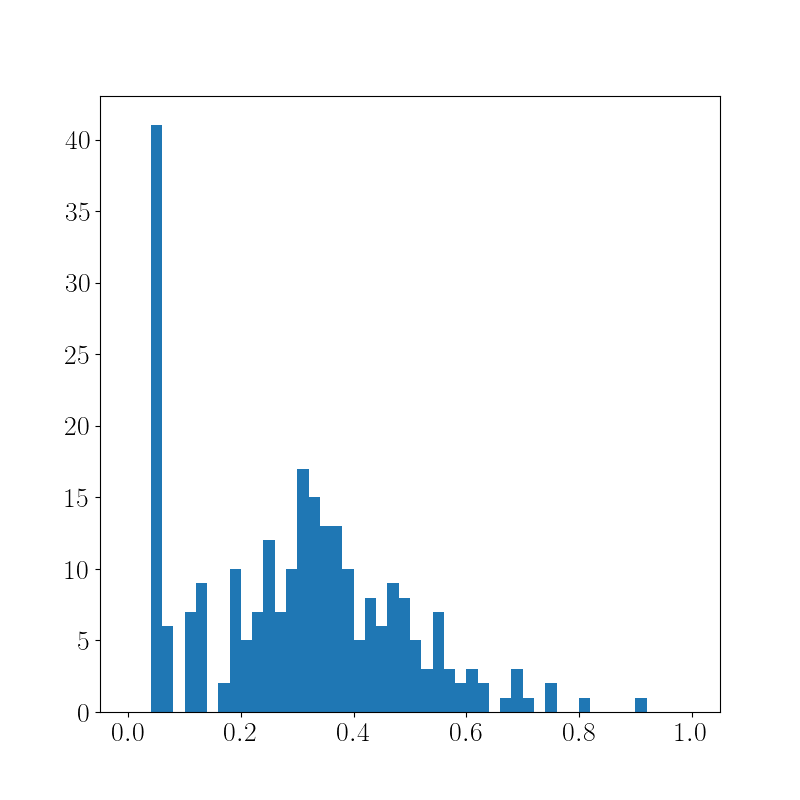

(array([ 0.,  0., 41.,  6.,  0.,  7.,  9.,  0.,  2., 10.,  5.,  7., 12.,
         7., 10., 17., 15., 13., 13., 10.,  5.,  8.,  6.,  9.,  8.,  5.,
         3.,  7.,  3.,  2.,  3.,  2.,  0.,  1.,  3.,  1.,  0.,  2.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

In [48]:
plt.figure()
plt.hist(total_error, range=(0,1), bins=50)


In [51]:
np.median(total_error)

0.3155858858810725

256


256
